In [1]:
!unzip /content/covertype.zip -d /content/covertype


Archive:  /content/covertype.zip
  inflating: /content/covertype/covtype.data.gz  
  inflating: /content/covertype/covtype.info  
  inflating: /content/covertype/old_covtype.info  


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
columns = ["Elevation", "Aspect", "Slope","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm","Horizontal_Distance_To_Fire_Points"] +[f"Wilderness_Area_{i+1}" for i in range(4)] \
    +[f"Soil_Type_{i+1}" for i in range(40)] \
    +["Cover_Type"]
data = pd.read_csv("/content/covertype/covtype.data.gz", compression='gzip', header=None,names=columns)
data.head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area_1                   581012 non-null  int64
 11  Wilderness_Area_2                   581012 non-null 

Shape of the dataset: (581012, 56)
Class Categories: [5 2 1 7 3 6 4]


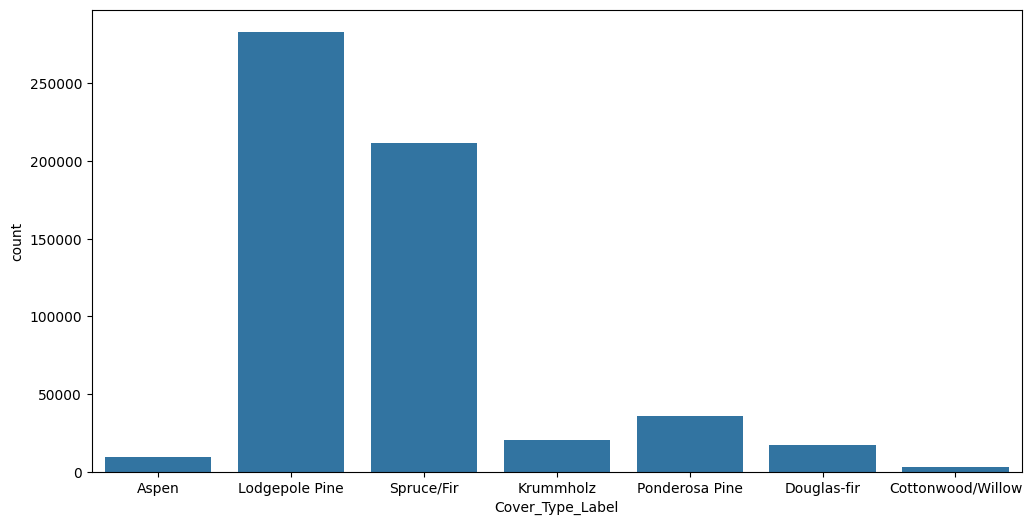

In [6]:
cover_map = {1:"Spruce/Fir",2:"Lodgepole Pine",3:"Ponderosa Pine",4:"Cottonwood/Willow",5:"Aspen",6:"Douglas-fir",7:"Krummholz"}
data["Cover_Type_Label"] = data["Cover_Type"].map(cover_map)
print(f'Shape of the dataset: {data.shape}')
print(f'Class Categories: {data.Cover_Type.unique()}')
plt.figure(figsize=(12, 6))
sns.countplot(x='Cover_Type_Label', data=data)
plt.show()

Pre-processing

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

num_cols= ["Elevation","Aspect","Slope", "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"]
bin_cols= [c for c in data.columns if c.startswith("Wilderness_Area_") or c.startswith("Soil_Type_")]
preprocess = ColumnTransformer(transformers=[("num", StandardScaler(), num_cols), ("bin", "passthrough", bin_cols)],remainder="drop")
X = data.drop(columns=["Cover_Type","Cover_Type_Label"])
y = data["Cover_Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Decision Trees

Accuracy: 0.9362581000490521
              precision    recall  f1-score   support

           1       0.94      0.94      0.94     42368
           2       0.95      0.95      0.95     56661
           3       0.92      0.92      0.92      7151
           4       0.82      0.80      0.81       549
           5       0.85      0.80      0.83      1899
           6       0.88      0.85      0.86      3473
           7       0.94      0.93      0.94      4102

    accuracy                           0.94    116203
   macro avg       0.90      0.89      0.89    116203
weighted avg       0.94      0.94      0.94    116203



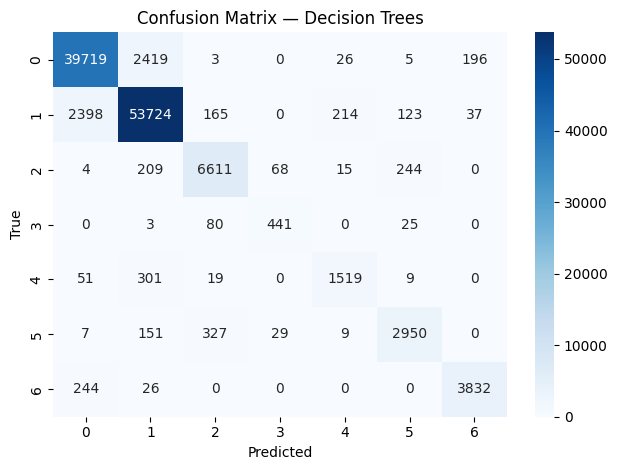

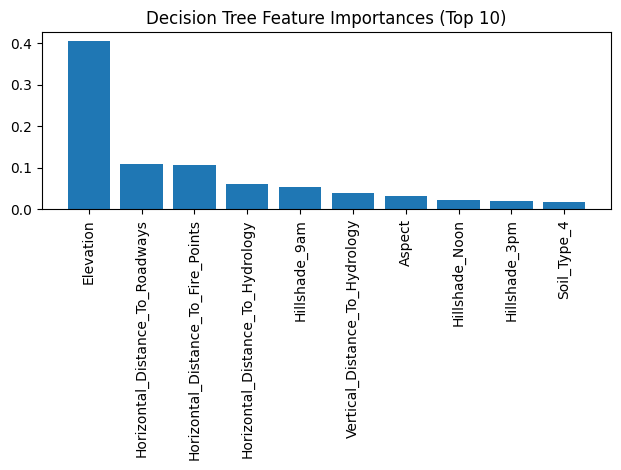

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[("prep", preprocess),("clf", DecisionTreeClassifier(max_depth=None, random_state=42, class_weight='balanced'))])
pipe.fit(X_train, y_train)
y_pred_dt = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

classes = np.unique(y_train)
cm = confusion_matrix(y_test, y_pred_dt, labels=sorted(classes))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Decision Trees")
plt.tight_layout(); plt.show()
print("\n")

dt_model = pipe.named_steps["clf"]
feature_names = pipe.named_steps["prep"].get_feature_names_out()
feature_names = [n.split("__")[-1] for n in feature_names]
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_idx = indices[:10]
feature_names_np = np.array(feature_names)
plt.bar(range(len(top_idx)), importances[top_idx], align="center")
plt.xticks(range(len(top_idx)), feature_names_np[top_idx], rotation=90)
plt.title("Decision Tree Feature Importances (Top 10)")
plt.tight_layout()
plt.show()



Random Forest

Accuracy: 0.9550183730196294
              precision    recall  f1-score   support

           1       0.97      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.91      0.85      0.88       549
           5       0.95      0.79      0.86      1899
           6       0.94      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.96    116203
   macro avg       0.95      0.91      0.93    116203
weighted avg       0.96      0.96      0.95    116203



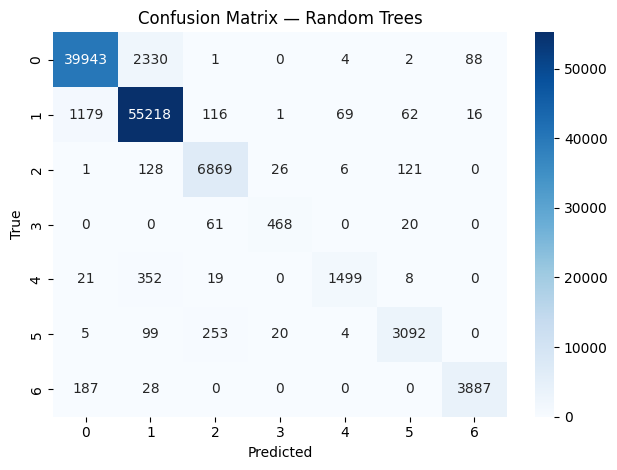

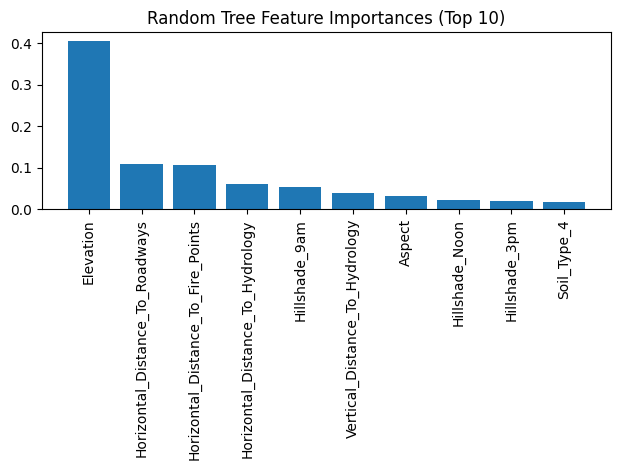

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([("prep", preprocess), ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced"))])
rf.fit(X_train, y_train)
y_pred_rf= rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

classes = np.unique(y_train)
cm = confusion_matrix(y_test, y_pred_rf, labels=sorted(classes))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Random Trees")
plt.tight_layout(); plt.show()
print("\n")

rt_model = pipe.named_steps["clf"]
feature_names = pipe.named_steps["prep"].get_feature_names_out()
feature_names = [n.split("__")[-1] for n in feature_names]
importances = rt_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_idx = indices[:10]
feature_names_np = np.array(feature_names)
plt.bar(range(len(top_idx)), importances[top_idx], align="center")
plt.xticks(range(len(top_idx)), feature_names_np[top_idx], rotation=90)
plt.title("Random Tree Feature Importances (Top 10)")
plt.tight_layout()
plt.show()

XGBoost


Accuracy: 0.9529
              precision    recall  f1-score   support

           1       0.95      0.95      0.95     42368
           2       0.96      0.95      0.96     56661
           3       0.95      0.97      0.96      7151
           4       0.89      0.92      0.90       549
           5       0.80      0.95      0.87      1899
           6       0.91      0.95      0.93      3473
           7       0.94      0.98      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.92      0.95      0.93    116203
weighted avg       0.95      0.95      0.95    116203



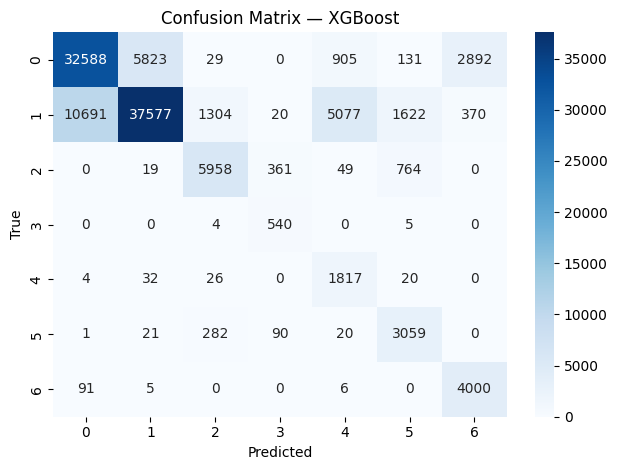

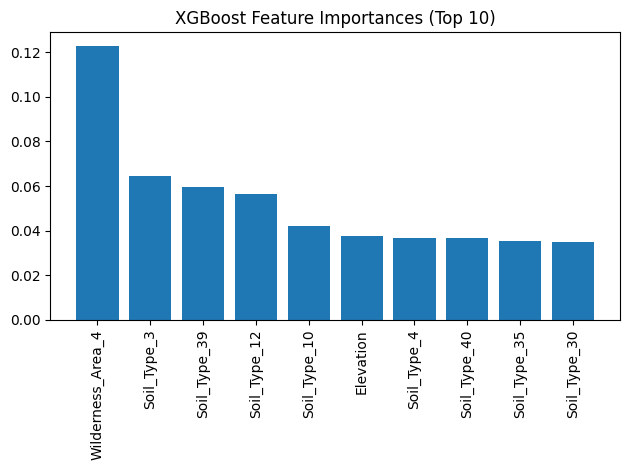

In [51]:
from sklearn.utils.class_weight import compute_class_weight

y_train_0 = y_train - 1
y_test_0  = y_test  - 1
X_tr, X_val, y_tr0, y_val0 = train_test_split(X_train, y_train_0, test_size=0.15, stratify=y_train_0, random_state=42)

classes = np.unique(y_tr0)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr0)
cw_map = {cls: w for cls, w in zip(classes, class_weights)}
cw_tr = np.array([cw_map[c] for c in y_tr0])
xgb_model = xgb.XGBClassifier(objective="multi:softprob",num_class=7,tree_method="hist",n_estimators=600,learning_rate=0.08,
    max_depth=10,subsample=0.8,colsample_bytree=0.8,reg_lambda=1.5,reg_alpha=0.5,min_child_weight=3,n_jobs=-1,random_state=42,
    eval_metric="mlogloss")
pipe = Pipeline([("prep", preprocess), ("clf", xgb_model)])
pipe.fit(X_tr, y_tr0,clf__sample_weight=cw_tr)
y_pred0 = pipe.predict(X_test)
y_pred  = y_pred0 + 1

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

classes = np.unique(y_train)
cm = confusion_matrix(y_test, y_pred_xg, labels=sorted(classes))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — XGBoost")
plt.tight_layout(); plt.show()
print("\n")

xg_model = pipe.named_steps["clf"]
feature_names = pipe.named_steps["prep"].get_feature_names_out()
feature_names = [n.split("__")[-1] for n in feature_names]
importances = xg_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_idx = indices[:10]
feature_names_np = np.array(feature_names)
plt.bar(range(len(top_idx)), importances[top_idx], align="center")
plt.xticks(range(len(top_idx)), feature_names_np[top_idx], rotation=90)
plt.title("XGBoost Feature Importances (Top 10)")
plt.tight_layout()
plt.show()


hypertuning Decision Tree

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

dt = Pipeline([("prep", preprocess),("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))])
param_ranges = {
    "clf__max_depth": randint(5, 30),
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 20),
    "clf__criterion": ["gini", "entropy"]
}

rand = RandomizedSearchCV(dt, param_distributions=param_ranges,n_iter=40, cv=5, scoring="accuracy",n_jobs=-1, random_state=42, verbose=1)
rand.fit(X_train, y_train)

print("Best parameters:", rand.best_params_)
print("Best CV score:", rand.best_score_)

#optimal parameters
best_dt = rand.best_estimator_
y_pred = best_dt.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 27, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 4}
Best CV score: 0.9169788038214334
Test accuracy: 0.9238229649836923
